## Problem Formulation

You can think of the job industry as the category or general field in which
you work. On a job application, **industry** refers to a broad category under
which a number of job titles can fall. For example, sales is an industry; job
titles under this category can include sales associate, sales manager,
manufacturing sales rep, pharmaceutical sales and so on.

You are required to build a model using any Machine Learning classifier
algorithm to classify job titles by the industry and provide us with insights
on how your model works.

## Import required packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk
from nltk.corpus import stopwords
import re
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import classification_report , accuracy_score 
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from joblib import load
from joblib import dump
import pickle

## Data Exploration

In [2]:
df = pd.read_csv('Job titles and industries.csv')

In [3]:
df.shape

(8586, 2)

In [4]:
df.columns

Index(['job title', 'industry'], dtype='object')

In [5]:
df.head()

,job title,industry
0,technical support and helpdesk supervisor - co...,IT
1,senior technical support engineer,IT
2,head of it services,IT
3,js front end engineer,IT
4,network and telephony controller,IT


In [6]:
df.tail()

,job title,industry
8581,data entry clerk,Marketing
8582,content creator,Marketing
8583,sales & marketing manager,Marketing
8584,marketing & digital marketing consultant,Marketing
8585,creative copywriter (arabic/english),Marketing


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8586 entries, 0 to 8585
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   job title  8586 non-null   object
 1   industry   8586 non-null   object
dtypes: object(2)
memory usage: 134.3+ KB


In [8]:
print(f"number of duplicates records = {len(df[df.duplicated()])}")

number of duplicates records = 4618


In [9]:
df['industry'].value_counts()

IT             4746
Marketing      2031
Education      1435
Accountancy     374
Name: industry, dtype: int64

# Cleaning Dataset

- Edit columns name
- Remove duplicate rows
- fix unbalance dataset
- Remove punctuation from text data
- Tokenization
- Remove stopwords
- Lemmatize/Stem

### Edit columns name

In [10]:
df.rename({'job title':'job_title'} , axis = 1 , inplace = True)
df.columns

Index(['job_title', 'industry'], dtype='object')

### Remove duplicate rows

In [11]:
df.drop_duplicates(subset=['job_title','industry'],keep='first',inplace=True)
df = df.reset_index(drop=True)

In [12]:
df.shape

(3968, 2)

### fix unbalance dataset

In [13]:
df['industry'].value_counts()

IT             1529
Marketing      1203
Education       973
Accountancy     263
Name: industry, dtype: int64

In [14]:
df_majority = df[df['industry'] == 'IT']
list_of_industry = df['industry'].value_counts().index.tolist()
df_copy = df_majority.copy()

In [15]:
def resample_data(df,df_copy):
    for col in list_of_industry:
        if col != 'IT':
            df_minority = df[df['industry'] == col]
            df_minority_unsample = resample(df_minority , replace = True , 
                                            n_samples = len(df_majority) , random_state=1)
            df_copy = df_copy.append(df_minority_unsample,)
            
    return df_copy

In [16]:
df2 = resample_data(df,df_copy)

In [17]:
df2.shape

(6116, 2)

In [18]:
df2['industry'].value_counts()

Marketing      1529
Accountancy    1529
IT             1529
Education      1529
Name: industry, dtype: int64

In [19]:
df = df2.copy()

### Remove punctuation from text data

In [20]:
def remove_punct(text):
    clean_text = "".join([char for char in text if char not in string.punctuation])
    return clean_text

In [21]:
df['job_title_cleaned'] = df['job_title'].apply(remove_punct)

In [22]:
df.head()

,job_title,industry,job_title_cleaned
0,technical support and helpdesk supervisor - co...,IT,technical support and helpdesk supervisor cou...
1,senior technical support engineer,IT,senior technical support engineer
2,head of it services,IT,head of it services
3,js front end engineer,IT,js front end engineer
4,network and telephony controller,IT,network and telephony controller


### Tokenization

In [23]:
def tokenize(text):
    tokens = re.split('\W+' , text)
    return tokens

In [24]:
df['job_title_tokens'] = df['job_title_cleaned'].apply(lambda x : tokenize(x.lower()))

In [25]:
df.head()

,job_title,industry,job_title_cleaned,job_title_tokens
0,technical support and helpdesk supervisor - co...,IT,technical support and helpdesk supervisor cou...,"[technical, support, and, helpdesk, supervisor..."
1,senior technical support engineer,IT,senior technical support engineer,"[senior, technical, support, engineer]"
2,head of it services,IT,head of it services,"[head, of, it, services]"
3,js front end engineer,IT,js front end engineer,"[js, front, end, engineer]"
4,network and telephony controller,IT,network and telephony controller,"[network, and, telephony, controller]"


### Remove stopwords

In [26]:
stop_words = stopwords.words('english')

In [27]:
def remove_stopwords(tokens):
    words = [token for token in tokens if token not in stop_words]
    return words

In [28]:
df['job_title_nostop'] = df['job_title_tokens'].apply(remove_stopwords)

In [29]:
df.head()

,job_title,industry,job_title_cleaned,job_title_tokens,job_title_nostop
0,technical support and helpdesk supervisor - co...,IT,technical support and helpdesk supervisor cou...,"[technical, support, and, helpdesk, supervisor...","[technical, support, helpdesk, supervisor, cou..."
1,senior technical support engineer,IT,senior technical support engineer,"[senior, technical, support, engineer]","[senior, technical, support, engineer]"
2,head of it services,IT,head of it services,"[head, of, it, services]","[head, services]"
3,js front end engineer,IT,js front end engineer,"[js, front, end, engineer]","[js, front, end, engineer]"
4,network and telephony controller,IT,network and telephony controller,"[network, and, telephony, controller]","[network, telephony, controller]"


### Lemmatize/Stem

In [30]:
wn = nltk.WordNetLemmatizer()

In [31]:
def lemmatize(words):
    lemma_words = [wn.lemmatize(word) for word in words]
    return lemma_words

In [32]:
df['job_title_lemmatized'] = df['job_title_nostop'].apply(lambda x: lemmatize(x))

In [33]:
df.head(10)

,job_title,industry,job_title_cleaned,job_title_tokens,job_title_nostop,job_title_lemmatized
0,technical support and helpdesk supervisor - co...,IT,technical support and helpdesk supervisor cou...,"[technical, support, and, helpdesk, supervisor...","[technical, support, helpdesk, supervisor, cou...","[technical, support, helpdesk, supervisor, cou..."
1,senior technical support engineer,IT,senior technical support engineer,"[senior, technical, support, engineer]","[senior, technical, support, engineer]","[senior, technical, support, engineer]"
2,head of it services,IT,head of it services,"[head, of, it, services]","[head, services]","[head, service]"
3,js front end engineer,IT,js front end engineer,"[js, front, end, engineer]","[js, front, end, engineer]","[j, front, end, engineer]"
4,network and telephony controller,IT,network and telephony controller,"[network, and, telephony, controller]","[network, telephony, controller]","[network, telephony, controller]"
5,privileged access management expert,IT,privileged access management expert,"[privileged, access, management, expert]","[privileged, access, management, expert]","[privileged, access, management, expert]"
6,devops engineers x 3 - global brand,IT,devops engineers x 3 global brand,"[devops, engineers, x, 3, global, brand]","[devops, engineers, x, 3, global, brand]","[devops, engineer, x, 3, global, brand]"
7,data modeller,IT,data modeller,"[data, modeller]","[data, modeller]","[data, modeller]"
8,"php web developer £45,000 based in london",IT,php web developer £45000 based in london,"[php, web, developer, 45000, based, in, london]","[php, web, developer, 45000, based, london]","[php, web, developer, 45000, based, london]"
9,solution / technical architect - ethical brand,IT,solution technical architect ethical brand,"[solution, technical, architect, ethical, brand]","[solution, technical, architect, ethical, brand]","[solution, technical, architect, ethical, brand]"


In [34]:
df['job_title_final'] = df['job_title_lemmatized'].apply(lambda x:" ".join(x))
df.head()

,job_title,industry,job_title_cleaned,job_title_tokens,job_title_nostop,job_title_lemmatized,job_title_final
0,technical support and helpdesk supervisor - co...,IT,technical support and helpdesk supervisor cou...,"[technical, support, and, helpdesk, supervisor...","[technical, support, helpdesk, supervisor, cou...","[technical, support, helpdesk, supervisor, cou...",technical support helpdesk supervisor county b...
1,senior technical support engineer,IT,senior technical support engineer,"[senior, technical, support, engineer]","[senior, technical, support, engineer]","[senior, technical, support, engineer]",senior technical support engineer
2,head of it services,IT,head of it services,"[head, of, it, services]","[head, services]","[head, service]",head service
3,js front end engineer,IT,js front end engineer,"[js, front, end, engineer]","[js, front, end, engineer]","[j, front, end, engineer]",j front end engineer
4,network and telephony controller,IT,network and telephony controller,"[network, and, telephony, controller]","[network, telephony, controller]","[network, telephony, controller]",network telephony controller


## Vectorizing Raw Data: TF-IDF

Creates a document-term matrix where the columns represent single unique terms (unigrams) but the cell represents a weighting meant to represent how important a word is to a document.

In [35]:
tfidf_vect = TfidfVectorizer()

In [36]:
X_tfidf = tfidf_vect.fit_transform(df['job_title_final'])
print(X_tfidf.shape)
print(tfidf_vect.get_feature_names())

(6116, 1921)
['0074', '02', '02fte', '03', '10', '100', '1000', '100120k', '11', '11551', '11teaching', '12', '120000', '125000', '12month', '12mth', '140000', '15', '150', '1500', '17000', '1719k', '175', '18', '18000', '18k', '19', '19000', '1st', '1st2nd', '1st3rd', '20', '200', '20000', '2016', '2018', '2019', '20k', '21000', '21000pa', '21k', '22000', '22k', '23', '23000', '23k', '24000', '24000christchurch', '247', '25', '250', '25000', '250350pd', '2535k', '25k', '26hr', '27000', '275', '27k', '28000', '2831000', '2835k', '285k', '28k', '29000', '299jc', '29k', '2d', '2nd', '2nd3rd', '300', '30000', '3040k', '3045k', '3050000', '30k', '31k', '32000', '325', '32k', '33000', '33k', '34', '35', '350', '35000', '35k', '35kembedded', '365', '37000', '38k', '3d', '3rd', '400', '40000', '4045000', '40k', '41700', '43k', '440per', '45', '450', '45000', '450pd', '4550000', '45k', '475pd', '48000', '50', '500', '50000', '50k', '55000', '5565000', '55k', '5g', '600', '6070k', '60k', '65700

In [37]:
X_tfidf = pd.DataFrame(X_tfidf.toarray())
X_tfidf.columns = tfidf_vect.get_feature_names()

## Feature Engineering

- create new column called **text_len** which count no of characters of text
- create new column called **count_punct**

In [38]:
df['text_len'] = df['job_title_final'].apply(lambda x:len(x) - x.count(' '))

In [39]:
def count_punct(text):
    c = sum([1 for char in text if char in string.punctuation])
    return c

In [40]:
df['count_punct'] = df['job_title'].apply(count_punct)

In [41]:
df.head()

,job_title,industry,job_title_cleaned,job_title_tokens,job_title_nostop,job_title_lemmatized,job_title_final,text_len,count_punct
0,technical support and helpdesk supervisor - co...,IT,technical support and helpdesk supervisor cou...,"[technical, support, and, helpdesk, supervisor...","[technical, support, helpdesk, supervisor, cou...","[technical, support, helpdesk, supervisor, cou...",technical support helpdesk supervisor county b...,59,2
1,senior technical support engineer,IT,senior technical support engineer,"[senior, technical, support, engineer]","[senior, technical, support, engineer]","[senior, technical, support, engineer]",senior technical support engineer,30,0
2,head of it services,IT,head of it services,"[head, of, it, services]","[head, services]","[head, service]",head service,11,0
3,js front end engineer,IT,js front end engineer,"[js, front, end, engineer]","[js, front, end, engineer]","[j, front, end, engineer]",j front end engineer,17,0
4,network and telephony controller,IT,network and telephony controller,"[network, and, telephony, controller]","[network, telephony, controller]","[network, telephony, controller]",network telephony controller,26,0


## Data Visualization :  Distribution for new columns

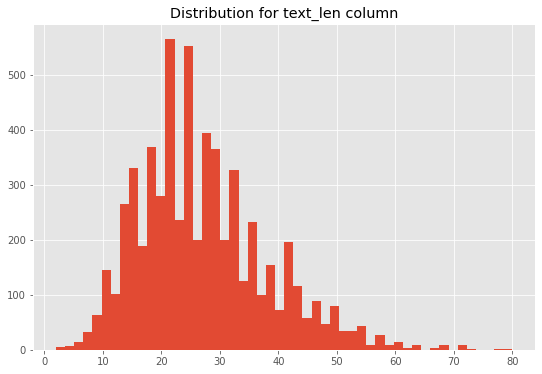

In [42]:
plt.style.use('ggplot')
fig , ax = plt.subplots(figsize=(9,6))
ax.hist(df['text_len'] , bins = 50)
ax.set_title('Distribution for text_len column')
plt.show()

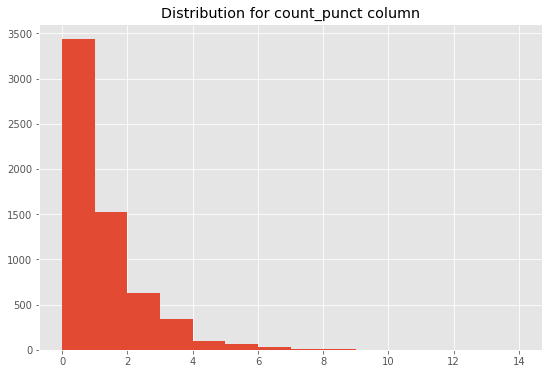

In [43]:
fig , ax = plt.subplots(figsize=(9,6))
ax.hist(df['count_punct'],bins=range(0,15))
ax.set_title('Distribution for count_punct column')
plt.show()

## Build Random Forest Classifer

In [44]:
X_features = df['job_title_final']
y = df['industry']

count_vect = CountVectorizer()
X_features_counts = count_vect.fit_transform(X_features)

tfidf_transformer = TfidfTransformer()
X_features_tfidf = tfidf_transformer.fit_transform(X_features_counts)

In [45]:
X_features_tfidf.shape

(6116, 1921)

In [46]:
X_train , X_test , y_train , y_test = train_test_split(X_features_tfidf , y , test_size = 0.2 , random_state=42)

In [47]:
rf = RandomForestClassifier()
rf_model = rf.fit(X_train, y_train)

In [48]:
y_pred = rf_model.predict(X_test)

In [49]:
comparsion = pd.DataFrame({'y_actual':y_test , 'y_predict':y_pred})
comparsion.head(10)

,y_actual,y_predict
3316,Accountancy,Accountancy
3134,Accountancy,Accountancy
2813,Education,Education
1554,Marketing,Marketing
3366,Accountancy,Accountancy
1402,Marketing,Marketing
3385,Accountancy,Accountancy
1836,Marketing,Marketing
2500,Education,Education
2672,Education,Education


In [50]:
score = accuracy_score(y_test , y_pred)
print(f"Accuracy = {round(score,5)*100}%")

Accuracy = 94.853%


In [51]:
print(classification_report(y_test, y_pred, 
                                    target_names=df['industry'].unique()))

              precision    recall  f1-score   support

          IT       0.98      1.00      0.99       291
   Marketing       0.95      0.95      0.95       285
   Education       0.98      0.88      0.93       331
 Accountancy       0.90      0.97      0.93       317

    accuracy                           0.95      1224
   macro avg       0.95      0.95      0.95      1224
weighted avg       0.95      0.95      0.95      1224



In [52]:
rf_model.predict(count_vect.transform(['software developer']))

array(['IT'], dtype=object)

In [53]:
rf_model.predict(count_vect.transform(['teacher']))

array(['Education'], dtype=object)

## Save our model

In [54]:
fileName = 'rf_model.pkl'

In [55]:
with open(fileName , 'wb') as f:
    pickle.dump((count_vect , rf_model),f)

In [56]:
with open(fileName,'rb') as f:
    count_vectorizer , model = pickle.load(f)

In [57]:
model.predict(count_vectorizer.transform(['copywriter']))

array(['Marketing'], dtype=object)